# Question: Do top‑team drivers have significantly faster average lap times than other drivers across the last 10 seasons?

##### Null Hypothesis: Top-team drivers don't have significantly faster average lap times than midfield drivers.

##### Alternate Hypothesis: Top-team drivers do have significantly faster average lap times than midfield drivers.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

First, we will identify what is considered a "top-team" by looking at which teams have the most world championships

In [73]:
# Load data
cs = pd.read_csv("world_champion_data/constructor_standings.csv")
r = pd.read_csv("world_champion_data/races.csv")
ctors = pd.read_csv("world_champion_data/constructors.csv")

In [134]:
# Define your canonical‑name mapping for legacy constructors
mapping = {
    "Renault":       "Alpine F1 Team",
    "Benetton":      "Alpine F1 Team",
    "Toro Rosso":    "AlphaTauri",
    "Red Bull":      "Red Bull Racing",
    "RB F1 Team":    "Red Bull Racing",
    "Force India":   "Aston Martin",
    "Racing Point":  "Aston Martin",
    "Brawn":         "Mercedes",
    "Sauber":        "Alfa Romeo",
    "BMW Sauber":    "Alfa Romeo",
}

# Identify the last race of each season
last_rounds = r.groupby("year")["round"].max().reset_index()
final_races = pd.merge(r, last_rounds, on=["year", "round"], how="inner")[["year", "raceId"]]

# Filter for the world champion in each season
world_champs = (
    cs
      .merge(final_races, on="raceId", how="inner")
      .loc[lambda df: df["position"] == 1]
      .merge(ctors[["constructorId", "name"]], on="constructorId", how="left")
      .loc[:, ["year", "name"]]
      .sort_values("year")
      .reset_index(drop=True)
)

# Apply the mapping to get a 'canonical' constructor name
world_champs["constructor"] = world_champs["name"].replace(mapping)

# Count how many titles each canonical constructor has
champ_counts = world_champs["constructor"].value_counts().sort_values(ascending=False)

# Current teams
current_year = r["year"].max()
active_ids   = (
    cs
      .merge(r[["raceId", "year"]], on="raceId")
      .query("year == @current_year")["constructorId"]
      .unique()
)
active_names    = ctors.loc[ctors["constructorId"].isin(active_ids), "name"]
canonical_active = active_names.replace(mapping)

current_champs = champ_counts.loc[champ_counts.index.isin(canonical_active)]


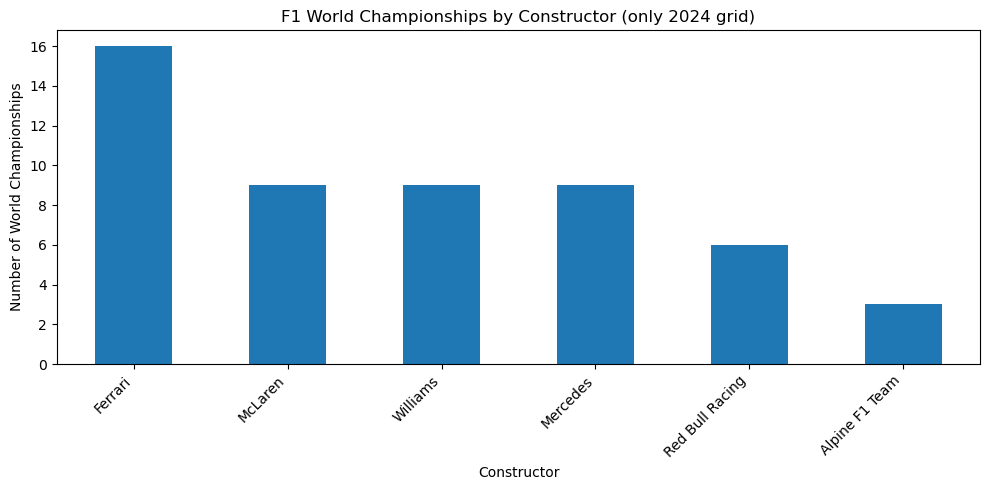

In [135]:
# Plot
to_plot = current_champs
plt.figure(figsize=(10,5))
to_plot.plot(kind="bar")
plt.xlabel("Constructor")
plt.ylabel("Number of World Championships")
plt.title(f"F1 World Championships by Constructor (only {current_year} grid)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Next, we will confirm top-teams by looking at total race wins

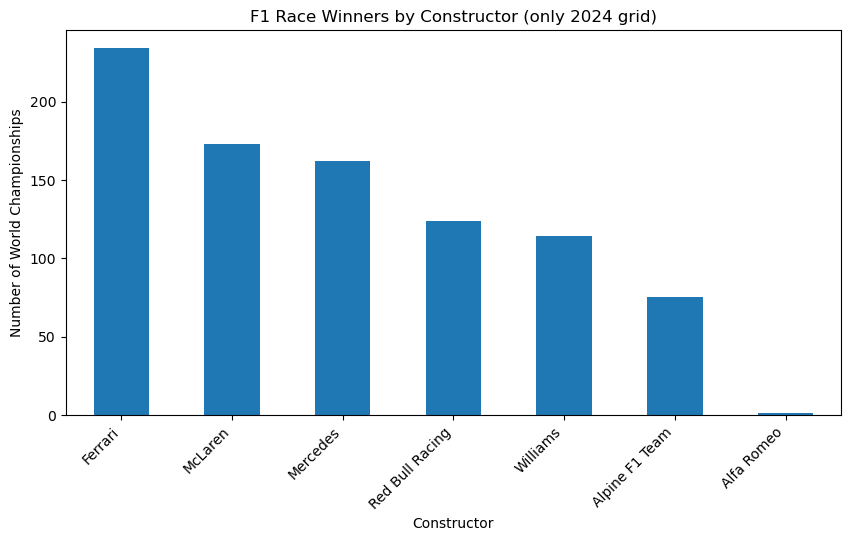

In [ ]:
# Clean up any stray whitespace
ctors.columns = ctors.columns.str.strip()

# Define your canonical‑name mapping for legacy constructors
mapping = {
    "Renault":       "Alpine F1 Team",
    "Benetton":      "Alpine F1 Team",
    "Toro Rosso":    "AlphaTauri",
    "Red Bull":      "Red Bull Racing",
    "RB F1 Team":    "Red Bull Racing",
    "Force India":   "Aston Martin",
    "Racing Point":  "Aston Martin",
    "Brawn":         "Mercedes",
    "Sauber":        "Alfa Romeo",
    "BMW Sauber":    "Alfa Romeo",
}

# Build race_winners with the year and constructor name
race_winners = (
    cs[cs["position"] == 1]
      .merge(r[["raceId","year"]], on="raceId", how="left")
      .merge(ctors[["constructorId","name"]], on="constructorId", how="left")
      .loc[:, ["year","name"]]
      .sort_values("year")
      .reset_index(drop=True)
)

# Create a 'canonical' column by applying the mapping
race_winners["canonical"] = race_winners["name"].replace(mapping)

# Count total world titles per canonical constructor name
counts = race_winners["canonical"].value_counts().sort_values(ascending=False)

# Find the most recent season
current_year = r["year"].max()

# Get the IDs of constructors who raced this season
active_ids = (
    cs
    .merge(r[["raceId","year"]], on="raceId", how="left")
    .query("year == @current_year")["constructorId"]
    .unique()
)

# Map those IDs back to their raw 'name', then to 'canonical'
active_names = ctors.loc[ctors["constructorId"].isin(active_ids), "name"]
canonical_active = active_names.replace(mapping)

# Filter your title counts down to only active teams
current_counts = counts.loc[counts.index.isin(canonical_active)]

# Plot
plt.figure(figsize=(10,5))
current_counts.plot(kind="bar")
plt.xlabel("Constructor")
plt.ylabel("Number of World Championships")
plt.title(f"F1 Race Winners by Constructor (only {current_year} grid)")
plt.xticks(rotation=45, ha="right")
plt.show()

In [184]:
active_teams = np.array(active_names)

top_teams = np.array(current_counts.head(4).index)

print(f"Active Teams: {active_teams}\nTop Teams: {top_teams}")

Active Teams: ['McLaren' 'Williams' 'Ferrari' 'Red Bull' 'Sauber' 'Aston Martin'
 'Mercedes' 'Haas F1 Team' 'Alpine F1 Team' 'RB F1 Team']
Top Teams: ['Ferrari' 'McLaren' 'Mercedes' 'Red Bull Racing']


Excellent, now we have determined that the top-teams are Ferrari, McLaren, Mercedes, and Red Bull Racing. 

In [ ]:
# Load data
lap = pd.read_csv("world_champion_data/lap_times.csv")
races = pd.read_csv("world_champion_data/races.csv")
results = pd.read_csv("world_champion_data/results.csv")
ctors = pd.read_csv("world_champion_data/constructors.csv")

# Clean up constructor names
ctors.columns = ctors.columns.str.strip()

# Map names
mapping = {
    "Renault":       "Alpine F1 Team",
    "Benetton":      "Alpine F1 Team",
    "Toro Rosso":    "AlphaTauri",
    "Red Bull":      "Red Bull Racing",
    "RB F1 Team":    "Red Bull Racing",
    "Force India":   "Aston Martin",
    "Racing Point":  "Aston Martin",
    "Brawn":         "Mercedes",
    "Sauber":        "Alfa Romeo",
    "BMW Sauber":    "Alfa Romeo",
}

# Identify the last 10 seasons (including the current one)
current_year = races["year"].max()
start_year   = current_year - 9
race_ids_10y = races.loc[
    races["year"].between(start_year, current_year),
    "raceId"
]

# Filter lap times to those seasons
lap_10y = lap[lap["raceId"].isin(race_ids_10y)]

# Merge in constructorId via results, then constructor name
lap_10y = (
    lap_10y
    .merge(results[["raceId","driverId","constructorId"]],
           on=["raceId","driverId"], how="left")
    .merge(ctors[["constructorId","name"]],
           on="constructorId", how="left")
)

# Map to your canonical team names
lap_10y["team"] = lap_10y["name"].replace(mapping)

# Define top‑4 teams (by historical world titles) and midfield
top_teams     = current_counts.head(4).index.to_list()
all_teams_10y = np.unique(lap_10y["team"])
midfield     = np.setdiff1d(all_teams_10y, top_teams)

# Extract lap times (ms) for each group
top_laps = lap_10y.loc[lap_10y["team"].isin(top_teams), "milliseconds"]
mid_laps = lap_10y.loc[lap_10y["team"].isin(midfield),    "milliseconds"]

# 10. Compute group means
print(f"Top‑team mean lap time (2014–{current_year}):     {top_laps.mean():.2f} ms")
print(f"Midfield mean lap time (2014–{current_year}):     {mid_laps.mean():.2f} ms\n")

# 11. t‑test
t_stat, p_value = stats.ttest_ind(top_laps, mid_laps, equal_var=False)
print(f"T‑statistic = {t_stat:.3f}, p‑value = {p_value:.3f}")

# Interpretation: p < 0.05 indicates a statistically significant difference

Top‑team mean lap time (2014–2024):     96188.08 ms
Midfield mean lap time (2014–2024):     97004.45 ms

T‑statistic = -2.555, p‑value = 0.011


In [ ]:
import statsmodels.formula.api as smf

# 1. Start from lap_10y (which has raceId, milliseconds, team, etc.)
df = lap_10y.copy()

# 2. Bring in circuitId
df = df.merge(
    races[['raceId','circuitId']],
    on='raceId',
    how='left'
)

# 3. Define your top‑team indicator
df['is_top'] = df['team'].isin(top_teams).astype(int)

# 4. Fit the OLS with circuit fixed effects
model = smf.ols("milliseconds ~ is_top + C(circuitId)", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           milliseconds   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     203.5
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:56:28   Log-Likelihood:            -2.8673e+06
No. Observations:              227123   AIC:                         5.735e+06
Df Residuals:                  227090   BIC:                         5.735e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.022e+05    849

In [190]:
print("is_top coef:   ", model.params["is_top"])
print("std err:       ", model.bse["is_top"])
print("t‑statistic:   ", model.tvalues["is_top"])
print("p‑value:       ", model.pvalues["is_top"])


is_top coef:    -1148.5811732563318
std err:        313.27297311634516
t‑statistic:    -3.66639088533745
p‑value:        0.0002460538675479424


With a coefficient of: -1148.581, this means that the top-team drivers are significantly faster than other drivers.

How has the lap‑time gap between top‑team and midfield drivers evolved year by year, 2014–2024?

Slope = -43.6 ms/year (p=0.601), R²=0.036


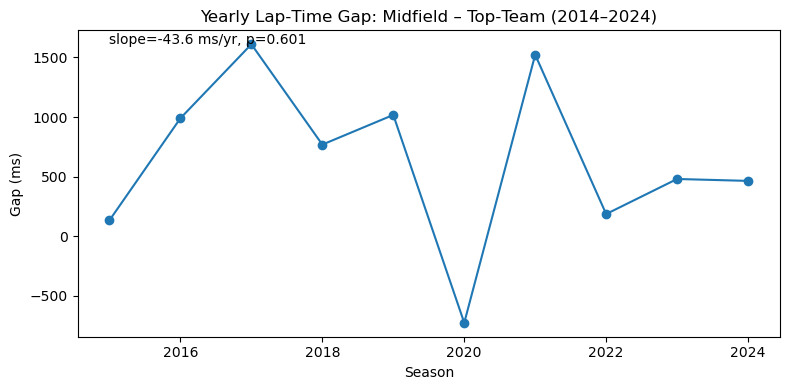

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# assume lap_10y, top_teams and races are already defined

# 0. merge in year
lap_10y = lap_10y.merge(
    races[['raceId','year']],
    on='raceId',
    how='left'
)

# 1. Tag top vs midfield
lap_10y["is_top"] = lap_10y["team"].isin(top_teams)

# 2. Compute annual means
annual = (
    lap_10y
    .groupby(["year","is_top"])["milliseconds"]
    .mean()
    .unstack()
    .rename(columns={False:"midfield", True:"top"})
)

# 3. Compute the gap
annual["gap_ms"] = annual["midfield"] - annual["top"]

# 4. Trend test
slope, intercept, r, p, stderr = linregress(annual.index, annual["gap_ms"])
print(f"Slope = {slope:.1f} ms/year (p={p:.3f}), R²={r*r:.3f}")

# 5. Plot
plt.figure(figsize=(8,4))
plt.plot(annual.index, annual["gap_ms"], marker="o", linestyle="-")
plt.title("Yearly Lap‑Time Gap: Midfield – Top‑Team (2014–2024)")
plt.ylabel("Gap (ms)")
plt.xlabel("Season")
plt.text(annual.index.min(), annual["gap_ms"].max(),
         f"slope={slope:.1f} ms/yr, p={p:.3f}")
plt.tight_layout()
plt.show()
